In [92]:
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Patch as mpatch
from matplotlib.lines import Line2D as mline
import seaborn as sns

In [93]:
plt.style.use("seaborn")
sns.set_context("talk")
style_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [94]:
results = {
    i:pd.read_pickle(f"../basin_output_no_ints/{i}.pickle") for i in [
        "lower_col", "upper_col", "missouri", "pnw"
    ]
}

In [95]:
def combine_res_metrics(results):
    output = pd.DataFrame(columns=["site_name", "basin", "group", "metric", "value"])
    for basin, values in results.items():
        for group, data in values.items():
            metrics = data["metrics"].reset_index().rename(
                columns={"index":"site_name"}
            )
            try:
                # need to convert from cudf to pddf if needed
                metrics = metrics.to_pandas()
            except AttributeError as e:
                pass
            metrics = metrics.melt(id_vars=["site_name"], var_name="metric")
            metrics["basin"] = basin
            metrics["group"] = group
            output = pd.concat([output, metrics])
    return output

In [96]:
def get_mean_release(results):
    output = pd.Series(dtype=np.float64)
    for basin, values in results.items():
        for group, data in values.items():
            act = data["eval_data"]["actual"]
            means = act.groupby(act.index.get_level_values(0)).mean()
            try:
                # need to convert from cudf to pddf if needed
                means = means.to_pandas()
            except AttributeError as e:
                pass
            output = output.append(means)
    return output

In [97]:
def get_fit_metrics(copy_df):
    tree = {
        i:pd.read_pickle(f"../../results/basin_eval/{i}/treed_model/results.pickle")
        for i in ["upper_col", "lower_col", "tva", "missouri", "pnw"]
    }
    simp = {}
    for i in ["upper_col", "lower_col", "tva", "missouri", "pnw"]:
        try:
            df = pd.read_pickle(f"../../results/basin_eval/{i}/simple_model/results.pickle")
            simp[i] = df
        except FileNotFoundError as e:
            pass
    
    tree_metrics = {i:j["res_scores"] for i,j in tree.items()}
    simp_metrics = {i:j["res_scores"] for i,j in simp.items()}
    
    output = copy_df.copy()# = pd.DataFrame(columns=["site_name", "basin", "group", "metric", "value"])
    output = output.reset_index().drop("index", axis=1)
    for i, row in output.iterrows():
        name = row["site_name"]
        basin = row["basin"]
        group = row["group"]
        metric = row["metric"]
        if metric == "r2_score":
            my_metric = "NSE"
        elif metric == "rmse":
            my_metric = "RMSE"
            
        if group == "high_rt":
            try:
                value = tree_metrics[basin].loc[name, my_metric]
            except KeyError as e:
                print(f"Tree no {', '.join([name, basin, group, metric])}")
        else:
            try:
                value = simp_metrics[basin].loc[name, my_metric]
            except KeyError as e:
                print(f"Simp no {', '.join([name, basin, group, metric])}")
        output.loc[i] = [name, basin, group, metric, value]
    return output

In [98]:
metrics = combine_res_metrics(results)
fit_metrics = get_fit_metrics(metrics)

In [99]:
# fit_metrics = get_fit_metrics(metrics)

In [100]:
mean_release = get_mean_release(results)

In [101]:
for res, value in mean_release.items():
    metrics.loc[
        (metrics["site_name"] == res) & (metrics["metric"] == "rmse"), "value"
    ] *= 100 / value
for res, value in mean_release.items():
    fit_metrics.loc[
        (fit_metrics["site_name"] == res) & (fit_metrics["metric"] == "rmse"), "value"
    ] *= 100 / value

In [102]:
# replace pnw loc names
with open("../../pnw_data/meta_data/dam_abbrs.json", "r") as f:
    abbrs = json.load(f)
    
metrics["site_name"] = [abbrs.get(i)["name"] if i in abbrs else i for i in metrics["site_name"]]

In [103]:
# replace missouri names
mis_meta = pd.read_csv("../../missouri_data/hydromet_stations.csv")
names = []
for i in metrics["site_name"]:
    name = mis_meta.loc[mis_meta["ID"] == i, "Name"].str.split(",", expand=True).values
    if len(name) == 0:
        names.append(i)
    else:
        names.append(name[0][0])
metrics["site_name"] = names

In [104]:
metrics["site_name"] = metrics["site_name"].str.title()
metrics["site_name"] = metrics["site_name"].replace("Angostura Reservoir (Cheyenne River Blw Dam)", "Angostura Reservoir")
metrics["site_name"] = metrics["site_name"].str.replace("( Reservoir)|( Dam)", "", regex=True)

In [105]:
drop_res = ["Grand Coulee", "Brownlee", "Parker"]

In [106]:
plot_scores = metrics.loc[
    (metrics["metric"] == "r2_score") & ~(metrics["site_name"].isin(drop_res))
]

plot_rmse = metrics.loc[
    (metrics["metric"] == "rmse") & ~(metrics["site_name"].isin(drop_res))
]

In [107]:
basin_colors = {j:style_colors[i] for i,j in enumerate(["upper_col", "lower_col", "pnw", "missouri"])}
basin_hatch = {
    "upper_col":"/",
    "lower_col":"--",
    "pnw":"x",
    "missouri":"+"
}
group_hatch = {
    "high_rt":"/",
    "low_rt":"x",
    "ror":"--"
}

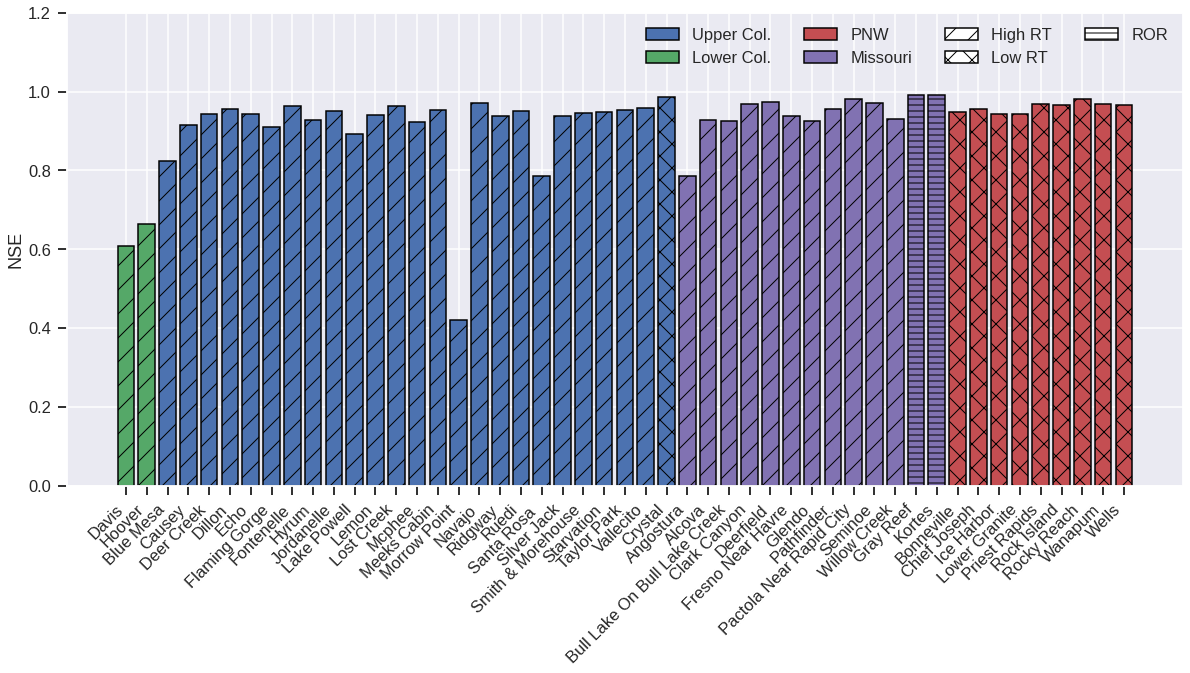

In [108]:
fig, ax = plt.subplots(1,1,figsize=(20,8.7))
colors = [basin_colors[i] for i in plot_scores["basin"]]
hatchs = [group_hatch[i] for i in plot_scores["group"]]
ax.bar(plot_scores["site_name"], plot_scores["value"], edgecolor="k", color=colors, hatch=hatchs)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(plot_scores["site_name"], ha="right", rotation=45)
handles = [
    mpatch(facecolor=basin_colors["upper_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["lower_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["pnw"], edgecolor="k"),
    mpatch(facecolor=basin_colors["missouri"], edgecolor="k"),
    mpatch(facecolor="w", edgecolor="k", hatch="/"),
    mpatch(facecolor="w", edgecolor="k", hatch="x"),
    mpatch(facecolor="w", edgecolor="k", hatch="--")
]
labels = ["Upper Col.", "Lower Col.", "PNW", "Missouri", "High RT", "Low RT", "ROR"]
ax.set_ylim(0, 1.2)
ax.legend(handles, labels, loc="best", ncol=4)
ax.set_ylabel("NSE")
plt.show()

In [109]:
import glob
def combine_res_meta():
    files = glob.glob(f"../basin_output_no_ints/*_meta.pickle")
    metas = [pd.read_pickle(f) for f in files]
    for i, m in enumerate(metas):
        try:
            metas[i] = m.to_pandas()
        except AttributeError as e:
            pass
    return pd.concat(metas, axis=0, ignore_index=False)

In [110]:
meta = combine_res_meta()

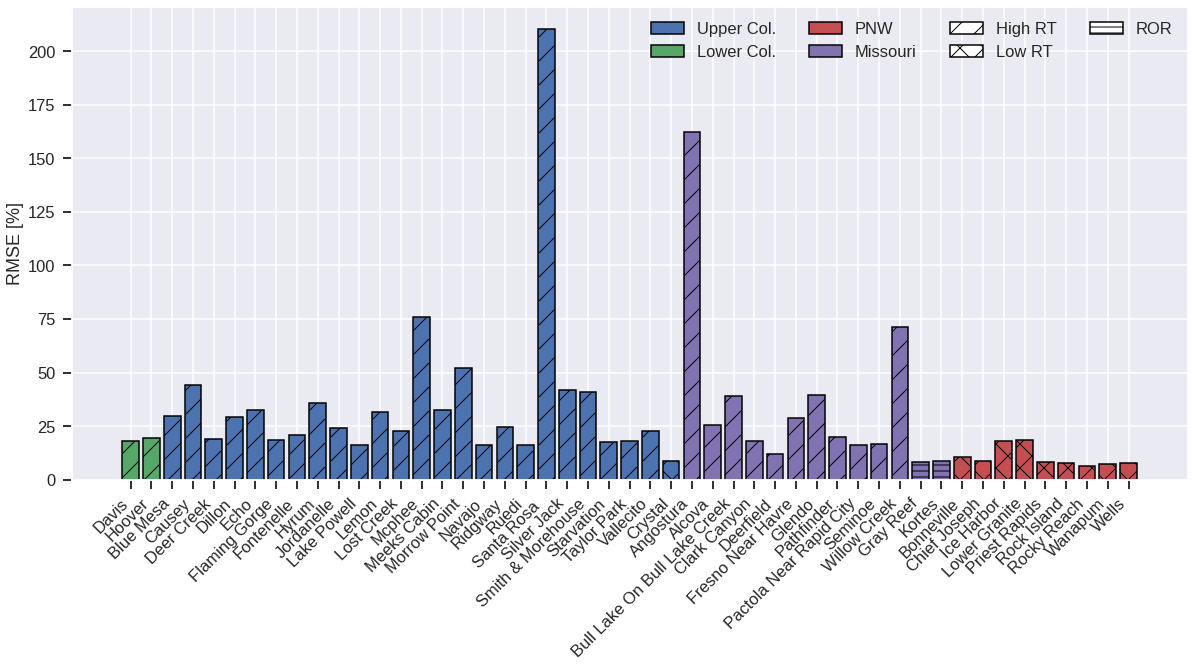

In [111]:
fig, ax = plt.subplots(1,1,figsize=(20,8.7))
colors = [basin_colors[i] for i in plot_rmse["basin"]]
hatchs = [group_hatch[i] for i in plot_rmse["group"]]
ax.bar(plot_rmse["site_name"], plot_rmse["value"], edgecolor="k", color=colors, hatch=hatchs)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(plot_rmse["site_name"], ha="right", rotation=45)
handles = [
    mpatch(facecolor=basin_colors["upper_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["lower_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["pnw"], edgecolor="k"),
    mpatch(facecolor=basin_colors["missouri"], edgecolor="k"),
    mpatch(facecolor="w", edgecolor="k", hatch="/"),
    mpatch(facecolor="w", edgecolor="k", hatch="x"),
    mpatch(facecolor="w", edgecolor="k", hatch="--")
]
labels = ["Upper Col.", "Lower Col.", "PNW", "Missouri", "High RT", "Low RT", "ROR"]
# ax.set_ylim(0, 1.2)
ax.legend(handles, labels, loc="best", ncol=4)
ax.set_ylabel("RMSE [%]")
plt.show()

In [112]:
metrics.loc[metrics.site_name.isin(drop_res)]

,site_name,basin,group,metric,value
2,Parker,lower_col,high_rt,r2_score,-5.240152
5,Parker,lower_col,high_rt,rmse,86.951154
0,Brownlee,pnw,high_rt,r2_score,-9.759523
1,Grand Coulee,pnw,high_rt,r2_score,-12.845361
2,Brownlee,pnw,high_rt,rmse,218.465217
3,Grand Coulee,pnw,high_rt,rmse,144.596474


In [113]:
# current ror reservoirs
meta[(meta["rel_inf_corr"] > 0.95) & (meta["max_sto"] < 10)]

,rts,rel_inf_corr,max_sto,group
site_name,,,,
Ocoee3,0.759982,0.965097,4.310083,ror
Wilbur,0.171809,0.996847,0.725950,ror
GRAR,1.182952,0.998254,1.860000,ror
KORR,3.785957,0.999829,5.595000,ror


In [114]:
# possible ror reservoirs
meta[meta["rel_inf_corr"] > 0.95]
# a ton of low_rt reservoirs could be considered ROR if we drop the 10000 acre-feet storage requirement

,rts,rel_inf_corr,max_sto,group
site_name,,,,
Apalachia,6.986486,0.952065,57.609917,low_rt
Chikamauga,4.055546,0.956040,844.468760,low_rt
FtLoudoun,4.493439,0.980853,408.172562,low_rt
FtPatrick,2.578731,0.982850,27.066446,low_rt
Guntersville,6.089700,0.951173,1504.936860,low_rt
Nikajack,1.769411,0.993987,392.929587,low_rt
Ocoee3,0.759982,0.965097,4.310083,ror
Pickwick,4.010568,0.977047,1206.148760,low_rt
Wilbur,0.171809,0.996847,0.725950,ror


In [115]:
# possible ror reservoirs if bump up to 0.99
meta[meta["rel_inf_corr"] > 0.99]

,rts,rel_inf_corr,max_sto,group
site_name,,,,
Nikajack,1.769411,0.993987,392.929587,low_rt
Wilbur,0.171809,0.996847,0.725950,ror
Wilson,3.108266,0.997787,641.337521,low_rt
CRYSTAL,10.525296,0.990221,20.097000,low_rt
BON,3.703203,0.996836,764.200000,low_rt
CHJ,5.370152,0.995557,589.200000,low_rt
IHR,7.725283,0.998876,414.100000,low_rt
LWG,9.089483,0.998465,482.143000,low_rt
PRD,0.267596,0.995518,44.171000,low_rt


In [116]:
fit_metrics["site_name"] = [abbrs.get(i)["name"] if i in abbrs else i for i in fit_metrics["site_name"]]
# replace missouri names
mis_meta = pd.read_csv("../../missouri_data/hydromet_stations.csv")
names = []
for i in fit_metrics["site_name"]:
    name = mis_meta.loc[mis_meta["ID"] == i, "Name"].str.split(",", expand=True).values
    if len(name) == 0:
        names.append(i)
    else:
        names.append(name[0][0])
fit_metrics["site_name"] = names
fit_metrics["site_name"] = fit_metrics["site_name"].str.title()
fit_metrics["site_name"] = fit_metrics["site_name"].replace("Angostura Reservoir (Cheyenne River Blw Dam)", "Angostura Reservoir")
fit_metrics["site_name"] = fit_metrics["site_name"].str.replace("( Reservoir)|( Dam)", "", regex=True)

In [117]:
plot_fit_scores = fit_metrics.loc[
    (fit_metrics["metric"] == "r2_score") & ~(fit_metrics["site_name"].isin(drop_res))
]

plot_fit_rmse = fit_metrics.loc[
    (fit_metrics["metric"] == "rmse") & ~(fit_metrics["site_name"].isin(drop_res))
]

In [118]:
basin_colors_2 = {j:sns.color_palette()[i] for i,j in enumerate(["upper_col", "lower_col", "pnw", "missouri"])}

In [119]:
plot_scores = plot_scores.sort_values(by=["basin", "value"])
plot_fit_scores = plot_fit_scores.sort_values(by=["basin", "value"])

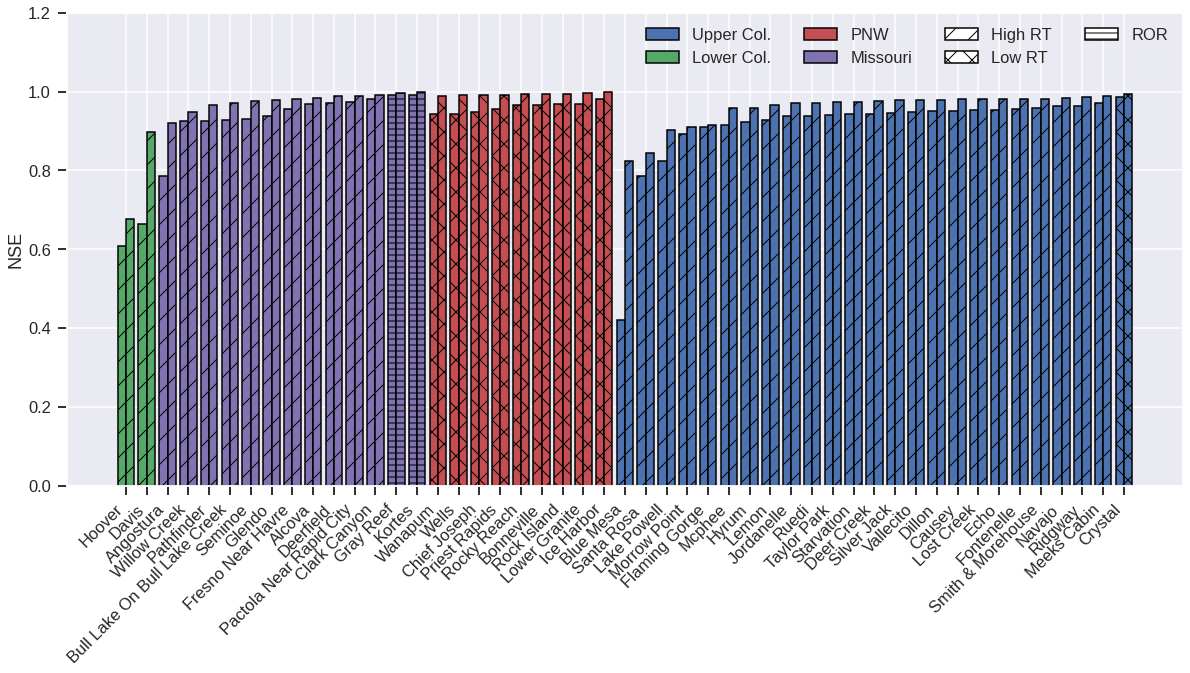

In [120]:
fig, ax = plt.subplots(1,1,figsize=(20,8.7))
colors = [basin_colors[i] for i in plot_scores["basin"]]
colors2 = [basin_colors_2[i] for i in plot_fit_scores["basin"]]
hatchs = [group_hatch[i] for i in plot_scores["group"]]
width = 0.4
lx = [i - width/2 for i in range(plot_scores.shape[0])]
rx = [i + width/2 for i in range(plot_fit_scores.shape[0])]
ax.bar(lx, plot_scores["value"], edgecolor="k", color=colors, hatch=hatchs, width=width)
ax.bar(rx, plot_fit_scores["value"], edgecolor="k", color=colors2, hatch=hatchs, width=width)
ax.set_xticks(range(plot_fit_scores.shape[0]))
ax.set_xticklabels(plot_fit_scores["site_name"], ha="right", rotation=45)
handles = [
    mpatch(facecolor=basin_colors["upper_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["lower_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["pnw"], edgecolor="k"),
    mpatch(facecolor=basin_colors["missouri"], edgecolor="k"),
    mpatch(facecolor="w", edgecolor="k", hatch="/"),
    mpatch(facecolor="w", edgecolor="k", hatch="x"),
    mpatch(facecolor="w", edgecolor="k", hatch="--")
]
labels = ["Upper Col.", "Lower Col.", "PNW", "Missouri", "High RT", "Low RT", "ROR"]
ax.set_ylim(0, 1.2)
ax.legend(handles, labels, loc="best", ncol=4)
ax.set_ylabel("NSE")
plt.show()

In [121]:
fit_metrics.loc[fit_metrics["site_name"].isin(drop_res)]

,site_name,basin,group,metric,value
2,Parker,lower_col,high_rt,r2_score,0.796236
5,Parker,lower_col,high_rt,rmse,15.712347
82,Brownlee,pnw,high_rt,r2_score,0.946763
83,Grand Coulee,pnw,high_rt,r2_score,0.839548
84,Brownlee,pnw,high_rt,rmse,15.367057
85,Grand Coulee,pnw,high_rt,rmse,15.566051


In [122]:
metrics.loc[metrics["site_name"].isin(drop_res)]

,site_name,basin,group,metric,value
2,Parker,lower_col,high_rt,r2_score,-5.240152
5,Parker,lower_col,high_rt,rmse,86.951154
0,Brownlee,pnw,high_rt,r2_score,-9.759523
1,Grand Coulee,pnw,high_rt,r2_score,-12.845361
2,Brownlee,pnw,high_rt,rmse,218.465217
3,Grand Coulee,pnw,high_rt,rmse,144.596474


In [125]:
mean_release.sort_values(ascending=False)

BON                            95.154643
PRD                            61.299112
WAN                            61.178356
RIS                            60.096033
RRH                            56.612094
WEL                            56.016992
CHJ                            53.643107
GCL                            53.082319
IHR                            26.104408
LWG                            25.230717
BRN                             8.365632
LAKE POWELL                     6.646160
Hoover                          6.381137
Davis                           6.274016
Parker                          4.582367
FLAMING GORGE                   1.081756
FONTENELLE                      0.824792
CRYSTAL                         0.750509
GLER                            0.735394
MORROW POINT                    0.698105
PATR                            0.663439
BLUE MESA                       0.649383
NAVAJO                          0.641105
SEMR                            0.626302
KORR            